# Solving MountainCar-v0 with PPO
This notebook demonstrates how to train a PPO agent on the MountainCar-v0 environment using Stable-Baselines3.

In [ ]:
!pip install stable-baselines3[extra] # gym[box2d]

  Using cached stable_baselines3-2.6.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl (363.4 MB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl (127.9 MB)
Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl (207.5 MB)
Using cached stable_baselines3-2.6.0-py3-none-any.whl (184 kB)
  Attempting uninstall: nvidia-cusparse-cu12
    Found existing installation: nvidia-cusparse-cu12 12.5.1.3
    Uninstalling nvid

In [ ]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import gymnasium as gym
# Create the environment and wrap it for monitoring
env = Monitor(gym.make('MountainCar-v0'), 'monitor.csv')

# Instantiate the PPO model
model = PPO('MlpPolicy', env, verbose=1)

# Train the agent
model.learn(total_timesteps=100000)

# Save the trained model
model.save('ppo_mountaincar')

Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -200     |
| time/              |          |
|    fps             | 1728     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 200         |
|    ep_rew_mean          | -200        |
| time/                   |             |
|    fps                  | 1190        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008565696 |
|    clip_fraction        | 0.0351      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_varia

In [ ]:
# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

Mean reward: -200.00 +/- 0.00


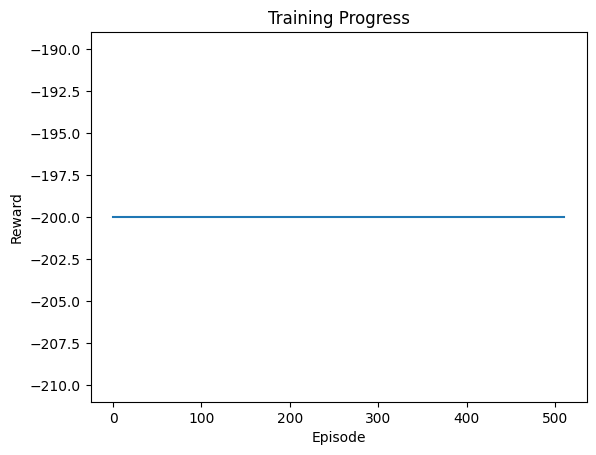

In [ ]:
# Plot training progress
from stable_baselines3.common.results_plotter import load_results

# Load the results from the monitor.csv file
results = load_results('./') # Pass the directory containing the monitor.csv file

# Plot the episode rewards
plt.plot(results['r']) # 'r' contains the episode rewards
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Progress')
plt.show()

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
np.bool8 = bool
# Hyperparameters
ENV_ID = "MountainCar-v0"
GAMMA = 0.99
GAE_LAMBDA = 0.95
CLIP_EPS = 0.2
LR = 3e-4
K_EPOCHS = 4       # how many times to reuse each rollout
MINI_BATCH_SIZE = 64
TIMESTEPS_PER_BATCH = 4096
MAX_UPDATES = 3000
ENTROPY_COEF = 0.01
VALUE_LOSS_COEF = 0.5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class ActorCritic(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        # shared backbone
        self.shared = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.ReLU(),
        )
        # policy head
        self.policy = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, act_dim),
            nn.Softmax(dim=-1),
        )
        # value head
        self.value = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        """
        Returns action probabilities and state-value estimate
        """
        x = self.shared(x)
        return self.policy(x), self.value(x).squeeze(-1)


class RolloutBuffer:
    def __init__(self):
        self.obs = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.dones = []
        self.values = []

    def clear(self):
        self.__init__()

    def compute_gae(self, next_value):
        """
        Compute GAE advantages and discounted returns
        """
        obs = np.array(self.obs)
        actions = np.array(self.actions)
        log_probs = np.array(self.log_probs)
        values = np.array(self.values + [next_value])
        rewards = np.array(self.rewards)
        dones = np.array(self.dones, dtype=int)

        advantages = np.zeros_like(rewards)
        gae = 0
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + GAMMA * values[t+1] * (1 - dones[t]) - values[t]
            gae = delta + GAMMA * GAE_LAMBDA * (1 - dones[t]) * gae
            advantages[t] = gae
        returns = advantages + values[:-1]
        return obs, actions, log_probs, returns, advantages


def train():
    env = gym.make(ENV_ID)
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n

    model = ActorCritic(obs_dim, act_dim).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    buffer = RolloutBuffer()
    obs = env.reset()
    ep_rewards = []
    update = 0

    while update < MAX_UPDATES:
        # collect rollouts
        for _ in range(TIMESTEPS_PER_BATCH):
            obs_tensor = torch.tensor(obs, dtype=torch.float32, device=DEVICE)
            with torch.no_grad():
                probs, value = model(obs_tensor)
            dist = Categorical(probs)
            action = dist.sample()
            log_prob = dist.log_prob(action).item()
            next_obs, reward, done, _ = env.step(action.item())

            buffer.obs.append(obs)
            buffer.actions.append(action.item())
            buffer.log_probs.append(log_prob)
            buffer.values.append(value.item())
            buffer.rewards.append(reward)
            buffer.dones.append(done)

            obs = next_obs
            if done:
                obs = env.reset()

        # compute advantage/returns
        with torch.no_grad():
            next_value = model(torch.tensor(obs, dtype=torch.float32, device=DEVICE))[1].item()
        (
            b_obs,
            b_actions,
            b_old_log_probs,
            b_returns,
            b_advantages
        ) = buffer.compute_gae(next_value)
        buffer.clear()

        # convert to tensors
        b_obs = torch.tensor(b_obs, dtype=torch.float32, device=DEVICE)
        b_actions = torch.tensor(b_actions, dtype=torch.long, device=DEVICE)
        b_old_log_probs = torch.tensor(b_old_log_probs, dtype=torch.float32, device=DEVICE)
        b_returns = torch.tensor(b_returns, dtype=torch.float32, device=DEVICE)
        b_advantages = torch.tensor(b_advantages, dtype=torch.float32, device=DEVICE)
        b_advantages = (b_advantages - b_advantages.mean()) / (b_advantages.std() + 1e-8)

        # PPO update
        for _ in range(K_EPOCHS):
            # create minibatches
            idxs = torch.randperm(TIMESTEPS_PER_BATCH)
            for start in range(0, TIMESTEPS_PER_BATCH, MINI_BATCH_SIZE):
                end = start + MINI_BATCH_SIZE
                mb_idx = idxs[start:end]

                obs_mb = b_obs[mb_idx]
                actions_mb = b_actions[mb_idx]
                old_logprobs_mb = b_old_log_probs[mb_idx]
                returns_mb = b_returns[mb_idx]
                adv_mb = b_advantages[mb_idx]

                # forward pass
                probs_mb, values_mb = model(obs_mb)
                dist_mb = Categorical(probs_mb)
                new_logprobs_mb = dist_mb.log_prob(actions_mb)
                entropy_mb = dist_mb.entropy().mean()

                # ratio for clipping
                ratio = torch.exp(new_logprobs_mb - old_logprobs_mb)

                # policy loss (clipped surrogate objective)
                surrogate1 = ratio * adv_mb
                surrogate2 = torch.clamp(ratio, 1 - CLIP_EPS, 1 + CLIP_EPS) * adv_mb
                policy_loss = -torch.min(surrogate1, surrogate2).mean()

                # value loss
                value_loss = nn.functional.mse_loss(values_mb, returns_mb)

                # total loss
                loss = policy_loss + VALUE_LOSS_COEF * value_loss - ENTROPY_COEF * entropy_mb

                # gradient step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        update += 1

        # (optional) print training info
        if update % 50 == 0:
            print(f"Update {update}/{MAX_UPDATES} — Loss: {loss.item():.3f}, "
                  f"Return: {b_returns.mean().item():.2f}")

    env.close()
    torch.save(model.state_dict(), "ppo_mountaincar_scratch.pt")
    print("Training complete.")

if __name__ == "__main__":
    train()


Update 50/3000 — Loss: 102.816, Return: -64.90
Update 100/3000 — Loss: 130.974, Return: -64.91
Update 150/3000 — Loss: 31.989, Return: -64.75
Update 200/3000 — Loss: 87.157, Return: -64.24
Update 250/3000 — Loss: 138.741, Return: -64.51
Update 300/3000 — Loss: 103.412, Return: -64.26
Update 350/3000 — Loss: 83.251, Return: -65.64
Update 400/3000 — Loss: 74.777, Return: -65.81
Update 450/3000 — Loss: 106.677, Return: -64.78
Update 500/3000 — Loss: 75.399, Return: -64.15
Update 550/3000 — Loss: 6.574, Return: -48.55
Update 600/3000 — Loss: 0.284, Return: -39.58
Update 650/3000 — Loss: 0.317, Return: -39.21
Update 700/3000 — Loss: 1.780, Return: -39.88
Update 750/3000 — Loss: 0.840, Return: -38.66
Update 800/3000 — Loss: 0.441, Return: -37.93
Update 850/3000 — Loss: 0.069, Return: -37.17
Update 900/3000 — Loss: 0.082, Return: -37.61
Update 950/3000 — Loss: 2.257, Return: -38.15
Update 1000/3000 — Loss: -0.039, Return: -36.44
Update 1050/3000 — Loss: -0.202, Return: -36.84
Update 1100/3000

In [82]:
from google.colab import drive
drive.mount('/content/drive')
save_path= "/content/drive/MyDrive/Collab Notebooks/"
#torch.save(model.state_dict(),

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical
import random
import numpy as np
import gym

# set device to cpu or cuda
device = torch.device('cpu')

if(torch.cuda.is_available()):
    device = torch.device('cuda:0')
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")

class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []


    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
                        nn.Linear(state_dim, hidden_dim),
                        nn.Tanh(),
                        nn.Linear(hidden_dim, hidden_dim),
                        nn.Tanh(),
                        nn.Linear(hidden_dim, action_dim),
                        nn.Softmax(dim=-1)
                    )


        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, hidden_dim),
                        nn.Tanh(),
                        nn.Linear(hidden_dim, hidden_dim),
                        nn.Tanh(),
                        nn.Linear(hidden_dim, 1)
                    )

    def act(self, state):

        action_probs = self.actor(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        action_logprob = dist.log_prob(action)

        return action.detach(), action_logprob.detach()


    def evaluate(self, state, action):

        action_probs = self.actor(state)
        dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)

        return action_logprobs, state_values, dist_entropy

class PPO:
    def __init__(self, state_dim, action_dim, hidden_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip):
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs

        self.buffer = RolloutBuffer()
        self.policy = ActorCritic(state_dim, action_dim, hidden_dim).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim, hidden_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()


    def select_action(self, state):

        with torch.no_grad():
            state = torch.FloatTensor(state).to(device)
            action, action_logprob = self.policy_old.act(state)

        self.buffer.states.append(state)
        self.buffer.actions.append(action)
        self.buffer.logprobs.append(action_logprob)

        return action.item()


    def update(self):

        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)


        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)

            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy

            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()


    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)


    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))

print("============================================================================================")

def seed_torch(seed):
        torch.manual_seed(seed)
        if torch.backends.cudnn.enabled:
            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True

####### initialize environment hyperparameters ######
env_name = "MountainCar-v0"
seed = 1
np.random.seed(seed)
random.seed(seed)
seed_torch(seed)

################ PPO hyperparameters ################
K_epochs = 40               # update policy for K epochs, ex. 5, 15, 30, 40, 80
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network
#####################################################

print("training environment name : " + env_name)

env = gym.make(env_name,new_step_api=True)

# state space dimension
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 64
################# training procedure ################

# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, hidden_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip)

num_epochs = 50000
update_epoch = 5
maxR = -200
os.makedirs('./data/', exist_ok=True)
for i_episode in range(num_epochs):

    state = env.reset()
    current_ep_reward = 0

    for t in range(300):

        # select action with policy
        action = ppo_agent.select_action(state)
        # Use the new step API which returns 5 values
        state, reward, terminated, truncated, _ = env.step(action)
        # In the new API, 'done' is equivalent to 'terminated or truncated'
        done = terminated or truncated

        # saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)

        current_ep_reward += reward

        if done:
            if i_episode % update_epoch == 0:
                ppo_agent.update()
            break



    if current_ep_reward > maxR:
      maxR = current_ep_reward
    if i_episode % 10 == 0:
      print("i_episode: ", i_episode, " current_ep_reward: ",current_ep_reward," maxR: ",maxR)

    if current_ep_reward > -110:
      fileN = './data/'+'E'+str(i_episode)+'_PPOMC_agent.pth'
      torch.save(ppo_agent.policy.actor.state_dict(),fileN)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
i_episode:  0  current_ep_reward:  -200.0  maxR:  -200
i_episode:  10  current_ep_reward:  -200.0  maxR:  -200
i_episode:  20  current_ep_reward:  -200.0  maxR:  -200
i_episode:  30  current_ep_reward:  -200.0  maxR:  -200
i_episode:  40  current_ep_reward:  -200.0  maxR:  -200
i_episode:  50  current_ep_reward:  -200.0  maxR:  -200
i_episode:  60  current_ep_reward:  -200.0  maxR:  -200
i_episode:  70  current_ep_reward:  -200.0  maxR:  -200
i_episode:  80  current_ep_reward:  -200.0  maxR:  -200
i_episode:  90  current_ep_reward:  -200.0  maxR:  -200
i_episode:  100  current_ep_reward:  -200.0  maxR:  -200
i_episode:  110  current_ep_reward:  -200.0  maxR:  -200
i_episode:  120  current_ep_reward:  -200.0  maxR:  -200
i_episode:  130  current_ep_reward:  -200.0  maxR:  -200
i_episode:  140  current_ep_reward:  -200.0  maxR:  -200
i_episode:  150  current_ep_reward:  -200.0  maxR:  -200
i_episode:  160  curr

In [142]:
!cp /content/data/E14342_PPOMC_agent.pth /content/drive/MyDrive/

In [141]:
print(os.getcwd())
os.chdir('/content/drive/MyDrive/')
print(os.getcwd())

/content/drive/MyDrive
/content/drive/MyDrive


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  self.output_truncation_bool = output_truncation_bool


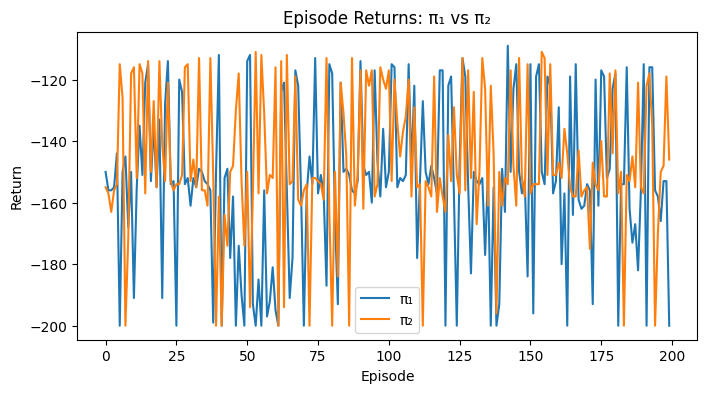

Pair 0: +(160 steps), -(179 steps)
Pair 1: +(116 steps), -(115 steps)
Pair 2: +(119 steps), -(118 steps)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [144]:
# 1) Install & import

import torch
import torch.nn as nn
from torch.distributions import Categorical
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from google.colab import files

# 2) Device & env setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
env = gym.make('MountainCar-v0')
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n
hidden_dim = 64

# 3) Define a bare nn.Sequential policy to match your saved state_dict keys
def make_policy():
    return nn.Sequential(
        nn.Linear(obs_dim, hidden_dim),  # key "0.weight"/"0.bias"
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),# key "2.weight"/"2.bias"
        nn.Tanh(),
        nn.Linear(hidden_dim, act_dim),  # key "4.weight"/"4.bias"
    ).to(device)

# 4) Load two policies from disk
def load_policy(path):
    policy = make_policy()
    ckpt = torch.load(path, map_location=device)
    policy.load_state_dict(ckpt)
    policy.eval()
    return policy

policy1 = load_policy('PI1_R-83.pth')
policy2 = load_policy('E14342_PPOMC_agent.pth')  # update path

# 5) Function to collect returns per episode
def collect_returns(policy, n_eps=200, max_steps=500):
    returns = []
    for _ in range(n_eps):
        obs = env.reset()
        state = obs[0] if isinstance(obs, tuple) else obs
        total_r = 0
        done = False
        for _ in range(max_steps):
            st = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                logits = policy(st)
                dist   = Categorical(logits=logits)
                action = dist.sample().item()
            step = env.step(action)
            if len(step) == 5:  # new Gymnasium API
                ns, r, term, trunc, _ = step
                done = term or trunc
            else:               # classic Gym
                ns, r, done, _ = step
            total_r += r
            state     = ns[0] if isinstance(ns, tuple) else ns
            if done:
                break
        returns.append(total_r)
    return returns

# 6) Collect & plot
rets1 = collect_returns(policy1)
rets2 = collect_returns(policy2)

plt.figure(figsize=(8,4))
plt.plot(rets1, label='π₁')
plt.plot(rets2, label='π₂')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('Episode Returns: π₁ vs π₂')
plt.legend()
plt.show()

# 7) Regenerate trajectories for π₁ (to match preference indices)
def generate_trajectories(policy, n_eps=200, max_steps=1000):
    trajs = []
    for _ in range(n_eps):
        obs = env.reset()
        state = obs[0] if isinstance(obs, tuple) else obs
        states, actions = [], []
        done = False
        for _ in range(max_steps):
            states.append(state)
            st = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                logits = policy(st)
                dist   = Categorical(logits=logits)
                action = dist.sample().item()
            step = env.step(action)
            if len(step) == 5:
                ns, r, term, trunc, _ = step
                done = term or trunc
            else:
                ns, r, done, _ = step
            actions.append(action)
            state = ns[0] if isinstance(ns, tuple) else ns
            if done:
                break
        trajs.append({'states': np.array(states), 'actions': np.array(actions)})
    return trajs

trajectories = generate_trajectories(policy1)

# 8) Load preference CSV and build list of [(state,action)+, (state,action)-]
df = pd.read_csv('preference_dataset.csv')
preference_list = []
for _, row in df.iterrows():
    i, j, pref = int(row.traj_i_idx), int(row.traj_j_idx), int(row.preference)
    traj_i, traj_j = trajectories[i], trajectories[j]
    sa_i = list(zip(traj_i['states'], traj_i['actions']))
    sa_j = list(zip(traj_j['states'], traj_j['actions']))
    if pref == 0:
        preference_list.append([sa_i, sa_j])  # i preferred over j
    else:
        preference_list.append([sa_j, sa_i])  # j preferred over i

# 9) Inspect a few examples
for idx, (pos, neg) in enumerate(preference_list[:3]):
    print(f"Pair {idx}: +({len(pos)} steps), -({len(neg)} steps)")

import json
import pandas as pd

# preference_list: List of [traj_pos, traj_neg], where each traj is [(state,action), ...]
# e.g. preference_list[0] = [ [(s0,a0), (s1,a1),...], [(t0,b0),(t1,b1),...] ]

rows = []
for traj_pos, traj_neg in preference_list:
    # split states/actions and convert to plain lists
    states_pos = [s.tolist() for s,a in traj_pos]
    actions_pos = [int(a) for s,a in traj_pos]
    states_neg = [s.tolist() for s,a in traj_neg]
    actions_neg = [int(a) for s,a in traj_neg]
    rows.append({
        'states_pos': json.dumps(states_pos),
        'actions_pos': json.dumps(actions_pos),
        'states_neg': json.dumps(states_neg),
        'actions_neg': json.dumps(actions_neg),
    })

# build dataframe and save
df_pref = pd.DataFrame(rows)
df_pref.to_csv('preference_trajectories.csv', index=False)

# download
from google.colab import files
files.download('preference_trajectories.csv')



/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  self.output_truncation_bool = output_truncation_bool


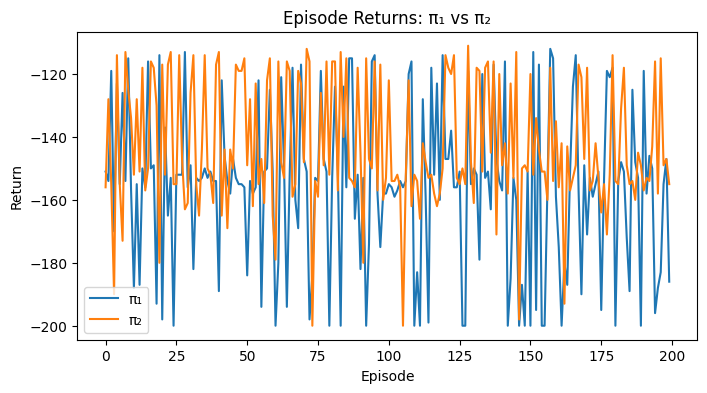

Pair 0: +(166 steps), -(123 steps)
Pair 1: +(114 steps), -(167 steps)
Pair 2: +(146 steps), -(178 steps)


FileNotFoundError: Cannot find file: preference_trajectories2.csv

In [145]:
# 1) Install & import

import torch
import torch.nn as nn
from torch.distributions import Categorical
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from google.colab import files

# 2) Device & env setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
env = gym.make('MountainCar-v0')
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n
hidden_dim = 64

# 3) Define a bare nn.Sequential policy to match your saved state_dict keys
def make_policy():
    return nn.Sequential(
        nn.Linear(obs_dim, hidden_dim),  # key "0.weight"/"0.bias"
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),# key "2.weight"/"2.bias"
        nn.Tanh(),
        nn.Linear(hidden_dim, act_dim),  # key "4.weight"/"4.bias"
    ).to(device)

# 4) Load two policies from disk
def load_policy(path):
    policy = make_policy()
    ckpt = torch.load(path, map_location=device)
    policy.load_state_dict(ckpt)
    policy.eval()
    return policy

policy1 = load_policy('PI1_R-83.pth')
policy2 = load_policy('E14342_PPOMC_agent.pth')  # update path

# 5) Function to collect returns per episode
def collect_returns(policy, n_eps=200, max_steps=500):
    returns = []
    for _ in range(n_eps):
        obs = env.reset()
        state = obs[0] if isinstance(obs, tuple) else obs
        total_r = 0
        done = False
        for _ in range(max_steps):
            st = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                logits = policy(st)
                dist   = Categorical(logits=logits)
                action = dist.sample().item()
            step = env.step(action)
            if len(step) == 5:  # new Gymnasium API
                ns, r, term, trunc, _ = step
                done = term or trunc
            else:               # classic Gym
                ns, r, done, _ = step
            total_r += r
            state     = ns[0] if isinstance(ns, tuple) else ns
            if done:
                break
        returns.append(total_r)
    return returns

# 6) Collect & plot
rets1 = collect_returns(policy1)
rets2 = collect_returns(policy2)

plt.figure(figsize=(8,4))
plt.plot(rets1, label='π₁')
plt.plot(rets2, label='π₂')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('Episode Returns: π₁ vs π₂')
plt.legend()
plt.show()

# 7) Regenerate trajectories for π₁ (to match preference indices)
def generate_trajectories(policy, n_eps=200, max_steps=1000):
    trajs = []
    for _ in range(n_eps):
        obs = env.reset()
        state = obs[0] if isinstance(obs, tuple) else obs
        states, actions = [], []
        done = False
        for _ in range(max_steps):
            states.append(state)
            st = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                logits = policy(st)
                dist   = Categorical(logits=logits)
                action = dist.sample().item()
            step = env.step(action)
            if len(step) == 5:
                ns, r, term, trunc, _ = step
                done = term or trunc
            else:
                ns, r, done, _ = step
            actions.append(action)
            state = ns[0] if isinstance(ns, tuple) else ns
            if done:
                break
        trajs.append({'states': np.array(states), 'actions': np.array(actions)})
    return trajs

trajectories = generate_trajectories(policy1)

# 8) Load preference CSV and build list of [(state,action)+, (state,action)-]
df = pd.read_csv('preference_dataset.csv')
preference_list = []
for _, row in df.iterrows():
    i, j, pref = int(row.traj_i_idx), int(row.traj_j_idx), int(row.preference)
    traj_i, traj_j = trajectories[i], trajectories[j]
    sa_i = list(zip(traj_i['states'], traj_i['actions']))
    sa_j = list(zip(traj_j['states'], traj_j['actions']))
    if pref == 0:
        preference_list.append([sa_i, sa_j])  # i preferred over j
    else:
        preference_list.append([sa_j, sa_i])  # j preferred over i

# 9) Inspect a few examples
for idx, (pos, neg) in enumerate(preference_list[:3]):
    print(f"Pair {idx}: +({len(pos)} steps), -({len(neg)} steps)")

import json
import pandas as pd

# preference_list: List of [traj_pos, traj_neg], where each traj is [(state,action), ...]
# e.g. preference_list[0] = [ [(s0,a0), (s1,a1),...], [(t0,b0),(t1,b1),...] ]

rows = []
for traj_pos, traj_neg in preference_list:
    # split states/actions and convert to plain lists
    states_pos = [s.tolist() for s,a in traj_pos]
    actions_pos = [int(a) for s,a in traj_pos]
    states_neg = [s.tolist() for s,a in traj_neg]
    actions_neg = [int(a) for s,a in traj_neg]
    rows.append({
        'states_pos': json.dumps(states_pos),
        'actions_pos': json.dumps(actions_pos),
        'states_neg': json.dumps(states_neg),
        'actions_neg': json.dumps(actions_neg),
    })

# build dataframe and save
df_pref = pd.DataFrame(rows)
df_pref.to_csv('preference_trajectories.csv', index=False)

# download
from google.colab import files
files.download('preference_trajectories2.csv')



In [146]:
df_pref.head()

,states_pos,actions_pos,states_neg,actions_neg
0,"[[-0.4160414934158325, 0.0], [-0.4178342223167...","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-0.5993933081626892, 0.0], [-0.5988297462463...","[1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, ..."
1,"[[-0.5804935097694397, 0.0], [-0.5790688395500...","[2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, ...","[[-0.5075040459632874, 0.0], [-0.5066247582435...","[2, 1, 1, 1, 2, 1, 1, 2, 1, 0, 0, 2, 0, 0, 1, ..."
2,"[[-0.5038367509841919, 0.0], [-0.5049848556518...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 2, ...","[[-0.5195366740226746, 0.0], [-0.5195671916007...","[1, 1, 2, 2, 2, 1, 2, 1, 0, 2, 1, 2, 2, 2, 2, ..."
3,"[[-0.5789759159088135, 0.0], [-0.5775625109672...","[2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, ...","[[-0.513809859752655, 0.0], [-0.51288324594497...","[2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, ..."
4,"[[-0.44642066955566406, 0.0], [-0.447994351387...","[0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-0.5736484527587891, 0.0], [-0.5722745060920...","[2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, ..."


In [151]:
import json
import pandas as pd
from google.colab import files

# 1) Load your trajectory‐level CSV
df = pd.read_csv('preference_trajectories.csv')

flat_rows = []
for _, row in df.iterrows():
    states_pos  = json.loads(row['states_pos'])
    actions_pos = json.loads(row['actions_pos'])
    states_neg  = json.loads(row['states_neg'])
    actions_neg = json.loads(row['actions_neg'])
    pref        = row.get('preference', None)  # if you logged this

    # align on the shorter trajectory
    L = min(len(states_pos), len(states_neg))
    for t in range(L):
        flat_rows.append({
            'state': states_pos[t],
            'action_pos': actions_pos[t],
            'action_neg': actions_neg[t],
            'preference': pref
        })

# 2) Build DataFrame and save
flat_df = pd.DataFrame(flat_rows)
# flat_df.to_csv('state_action_preference.csv', index=False)

# 3) Download
files.download('state_action_preference.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [150]:
flat_df.head(5)

,state,action_pos,action_neg,preference
0,"[-0.4160414934158325, 0.0]",0,1,None
1,"[-0.41783422231674194, -0.0017927541630342603]",1,2,None
2,"[-0.4204069674015045, -0.002572745317593217]",1,1,None
3,"[-0.4237413704395294, -0.0033343809191137552]",0,2,None
4,"[-0.42881351709365845, -0.005072159692645073]",0,2,None
